# Analiza zbioru danych 🎹 Spotify Tracks Dataset

W tym notatniku zaprezentowana zostanie analiza zbioru dannych [🎹 Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset). Najpierw przeprowadzona zostanie wstępna eksploracyjna analiza danych, a następnie wytrenowane zostaną modele, które przewidywać będą gatunek muzyki dla danej piosenki na podstawie atrybutów dostępnych w zbiorze danych.

### Import niezbędnych bibliotek oraz pakietów

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Opis zbioru danych

## Wczytanie zbioru danych oraz wstępne przetwarzanie

Z całego zbioru danych zostaną wyfiltrowane tylko niektóre gatunki, które nie zależą od pochodzenia/narodowości twórcy oraz które są popularne.

In [176]:
# rock, chill/relax, classical, pop/dance
GENRES_MAP = {
    'alt-rock': 'rock',
    'ambient': 'chill/relax',
    'chill': 'chill/relax',
    'classical': 'classical',
    'dance': 'pop/dance',
    'disco': 'pop/dance',
    'edm': 'pop/dance',
    'electro': 'pop/dance',
    'hard-rock': 'rock',
    'heavy-metal': 'rock',
    'hip-hop': 'pop/dance',
    'indie-pop': 'pop/dance',
    'opera': 'classical',
    'piano': 'classical',
    'pop': 'pop/dance',
    'punk-rock': 'rock',
    'rock-n-roll': 'rock',
    'rock': 'rock',
    'sleep': 'chill/relax',
    'study': 'chill/relax'
}
GENRES = list(GENRES_MAP.keys())
COLUMNS = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre']
COLUMNS_DUPLICATES = ['artists', 'track_name', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre']
COLUMNS_NUMERICAL = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
COLUMNS_NOMINAL = ['explicit', 'mode']

Przykładowe 5 próbek ze zbioru danych

In [196]:
df_original = pd.read_csv("data/dataset.csv", index_col=0)
print(df_original.track_genre.unique())
df_original = df_original[df_original['track_genre'].isin(GENRES)]
df_original['track_genre'] = df_original['track_genre'].replace(GENRES_MAP)
print(df_original.shape)

df_original.sample(5, random_state=8000)

['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
101617,7aqkiFyBFMmJPIT0hkY4MK,Loopable,Loopable Ambience of Brown Noise and Brown Waves,Pure Brown Noise - Loopable with no fade,34,71397,False,0.0000,0.0000,10,-17.5020,0,0.0000,0.0000,0.1240,0.6880,0.0000,0.0000,0,chill/relax
2213,6ngu6sBaJMM05mAVATApZJ,KALEO,Feeling Good - Adult Pop Favorites,Save Yourself,0,273880,False,0.5340,0.3380,0,-8.6080,0,0.0346,0.5150,0.0000,0.1240,0.1110,120.3990,4,rock
101307,1fMnqF3hdQWXiC5Amb9EI0,Lumi Couri,Luova,Luova,64,124805,False,0.0627,0.0020,5,-37.4860,1,0.0467,0.9840,0.8800,0.1130,0.0397,67.9960,4,chill/relax
76664,6K0Wsyte1xuEj9m4OxBeH3,Il Divo,Siempre,Amor Venme a Buscar,20,253426,False,0.4220,0.4190,7,-8.7610,0,0.0317,0.6550,0.0000,0.1040,0.0852,137.4090,4,classical
51088,5PjdY0CKGZdEuoNab3yDmX,The Kid LAROI;Justin Bieber,F*CK LOVE 3: OVER YOU,STAY (with Justin Bieber),86,141805,True,0.5910,0.7640,1,-5.4840,1,0.0483,0.0383,0.0000,0.1030,0.4780,169.9280,4,pop/dance


## Opis zbioru danych

Zbiór danych posiada 20 atrybutów. Pogrubioną czcionką oznaczone zostały te, które będą używane w dalszej analizie danych oraz podczas uczenia modeli.
1. track_id - unikalny identyfikator utworu w ramach Spotify,
2. artists - zbiór artystów, którzy są autorami piosenki,
3. album_name - nazwa albumu, na którym pojawia się piosenka,
4. track_name - nazwa piosenki,
5. **popularity** - popularność piosenki wyrażona na skali od 0 do 100. Wyliczana jest ona na podstawie algorytmu przygotowanego przez Spotify, który bierze pod uwagę takie czynniki jak liczba odtworzeń utworu w serwisie oraz ich aktualności (czy utwór jest popularny teraz czy w przeszłości),
6. **duration_ms** - długość trwania pionseki w milisekundach,
7. **explicit** - wartość bool określająca czy piosenka posiada niecenzuralne słowa,
8. **danceability** - wartość od 0.0 do 1.0 określająca jak bardzo piosenka nadaje się do tańczenia. Wartość wyliczana jest między innymi na podstawie tempa czy też stabilności rytmu,
9. **energy** - wartość od 0.0 do 1.0 reprezentująca miarę intensywności utworu. Przykładowo piosenki, które są szybkie, głośne oraz hałaśliwe mają wysoką wartość energii,
10. key - tonacja, w której jest piosenka określona w notacji [Pitch class](https://en.wikipedia.org/wiki/Pitch_class),
11. **loudness** - średnia głośność piosenki wyrażona w decybelach,
12. **mode** - określenie czy piosenka jest w tonacji dur (1) czy moll (0),
13. **speechiness** - wartość od 0.0 do 1.0 odpowiadająca za obecność słów w piosence. Przykładowo poezja czytana albo podcast posiada wartość 1.0,
14. **acousticness** - wartość od 0.0 do 1.0 określająca jak bardzo akustyczny jest utwór,
15. **instrumentalness** - wartość od 0.0 do 1.0 określająca czy utwór zawiera słowa. Przykładowo piosenki, które są zaklasyfikowane jako Rap będą miały niską wartość instrumentalness. Im większa wartość tego atrybutu, tym większa pewność, że utwór nie posiada słów,
16. liveness - wartość od 0.0 do 1.0 określająca pewność z jaką utwór został wykonany na żywo,
17. **valence** - wartość od 0.0 do 1.0 określająca jak bardzo pozytywny jest utwór. Piosenki, które mają wartość 1.0 na tym atrybucie będą radosne, a z małymi wartościami (bliskimi 0.0) będą smutne,
18. **tempo** - średnia tempo utworu [BPM](https://en.wikipedia.org/wiki/Tempo),
19. time_signature - oszacowane taktowanie utworu,
20. **track_genre** - gatunek muzyki, do którego należy piosenka.

In [179]:
df = df_original[COLUMNS].copy()

# Mapping key to object and mode to bool
df['mode'] = df['mode'].astype('bool')

df.dtypes

popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
valence             float64
tempo               float64
track_genre          object
dtype: object

Większość z rozważanych atrybutów jest typu int lub float, natomiast są również atrybuty nominalne takie jak: *explicit* przyjmująca wartość boolowską - Prawda lub Fałsz, *key* która mimo tego, że określana jako integer ma charakter kategoryczny (nie można powiedzieć że próbka przyjmująca wartość 1 jest na przykład gorsza/lepsza od próbki przyjmującej wartość 2 na tym atrybucie), *mode* przyjmująca wartość boolowską - Prawda jeżeli tonacja dur, Fałsz jeżeli tonacja moll.

In [180]:
df.isnull().values.any()

False

W przygotowanym zbiorze danych nie ma wartości brakujących.

In [181]:
df.describe()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
count,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000
mean,34.4948,210724.3839,0.5359,0.5700,-10.0312,0.0689,0.3770,0.2074,0.4406,117.6503
std,27.0183,100639.5189,0.1942,0.2845,7.2496,0.0650,0.3705,0.3578,0.2599,32.0120
min,0.0000,17453.0000,0.0000,0.0000,-49.5310,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,162897.0000,0.4090,0.3610,-12.0375,0.0354,0.0282,0.0000,0.2270,94.0385
50%,35.0000,200081.5000,0.5580,0.6130,-7.4725,0.0460,0.2220,0.0001,0.4310,118.1840
75%,59.0000,242437.5000,0.6860,0.8100,-5.2527,0.0712,0.7540,0.2182,0.6390,137.8893
max,100.0000,4120258.0000,0.9650,1.0000,1.0230,0.7660,0.9960,1.0000,0.9920,215.5130


W powyższej tabeli przedstawione zostały statystyki dotyczące każdego z atrybutów liczbowych. Można zauważyć, że dla niektórych modeli/klasyfikatorów trzeba będzie sprawdzić również wersję z normalizacją/standaryzacją danych, ponieważ istnieje duża różnica (parę rzędów wielkości) pomiędzy wartościami dla atrybutów np. duration_ms oraz acousticness.

In [183]:
print(f"Liczba próbek/przypadków: {len(df)}, liczba rozpatrywanych gatunków {len(GENRES)}")

df.groupby('track_genre').count()

Liczba próbek/przypadków: 20000, liczba rozpatrywanych gatunków 20


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
track_genre,,,,,,,,,,,,
chill/relax,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
classical,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000
pop/dance,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000
rock,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000


# Interpretacja przypadków ze zbioru danych

W tej sekcji przedstawione zostaną trzy konkretne przypadki ze zbioru danych.

In [184]:
# df.loc[[81137, 19611, 16058], :]

In [185]:
# df_original.loc[[81137, 19611, 16058], ['artists', 'album_name', 'track_name']]

##### Black Space - Taylor Swift - pop



##### Ain't It Fun - Paramore - emo



##### Nocturne In C-Sharp Minor, Op. Posth. - Frédéric Chopin;Dang Thai Son	- classical



# Eksploracyjna analiza danych

## Analiza atrybutów numerycznych

### Rozkład dla poszczególnych atrybutów
Dla atrybutów, które przyjmują wartości ciągłe wyświetlone zostaną histogramy z "Kernel density estimate (KDE)".

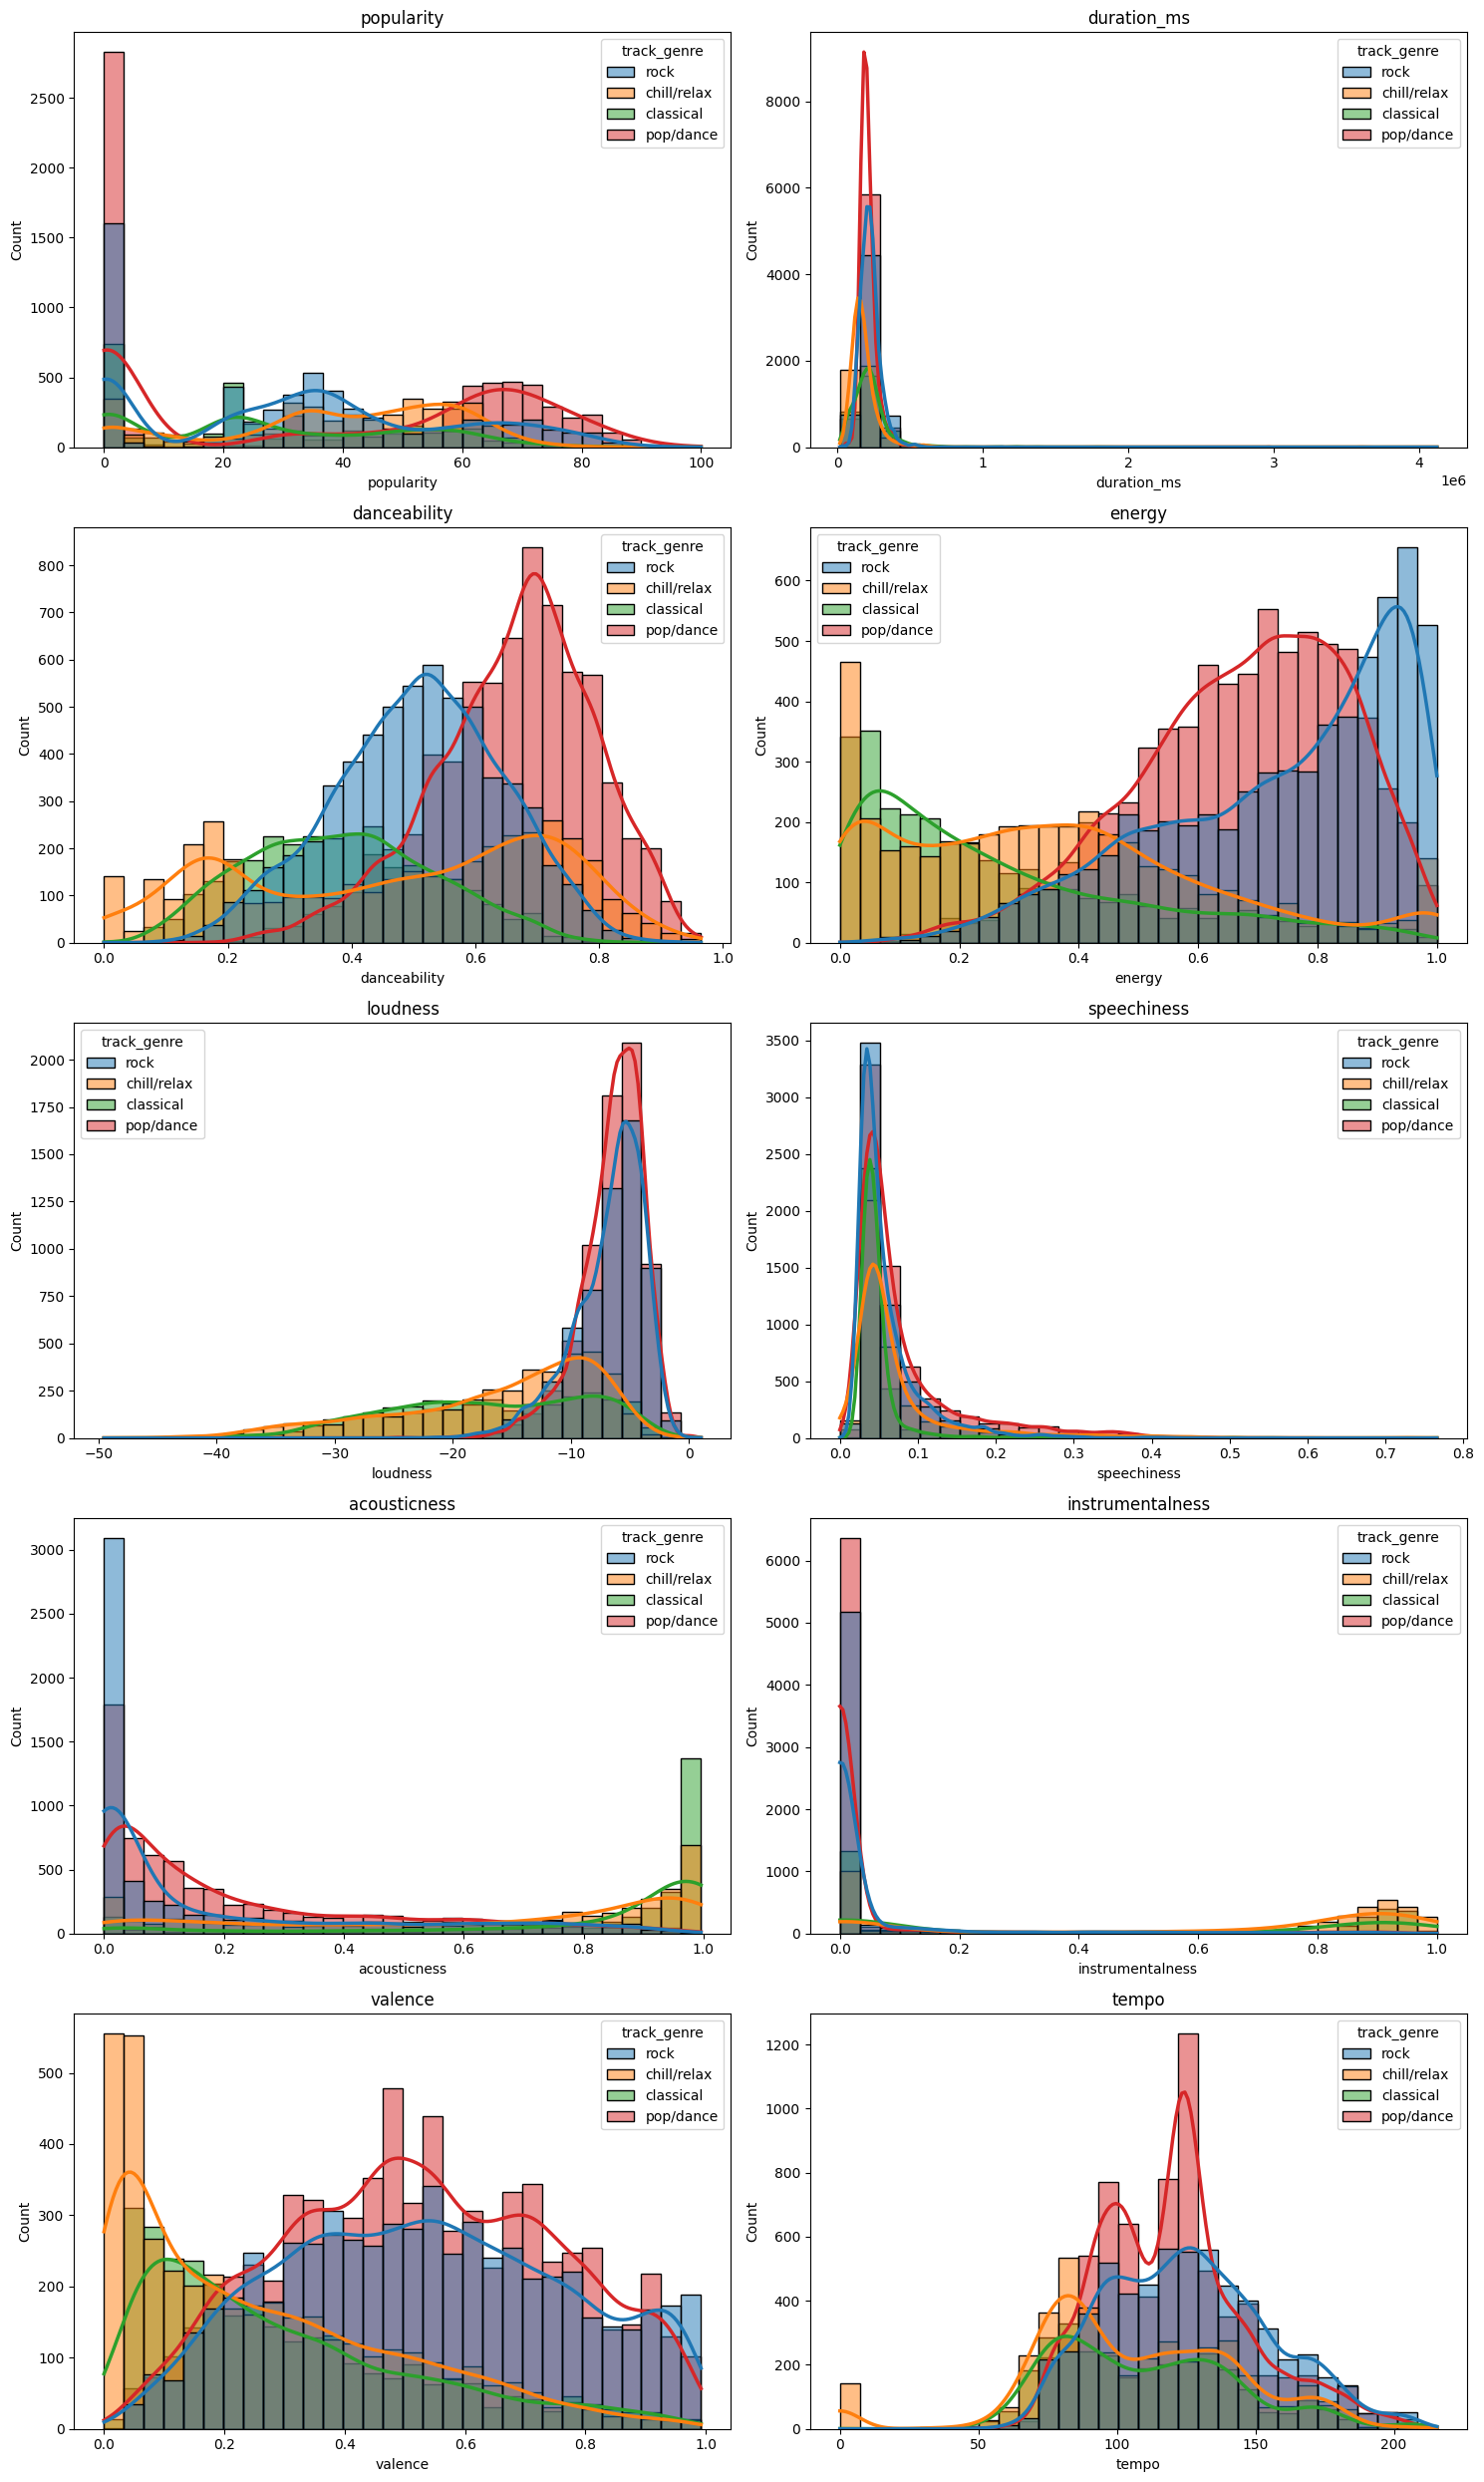

In [190]:
plt.figure(figsize=(15, 25))
for i, column in enumerate(COLUMNS_NUMERICAL):
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=df, x=column, bins=30, hue='track_genre', kde=True, line_kws={'linewidth': 2.5})
    plt.title(column)
plt.tight_layout()
plt.show()

### Macierz korelacji

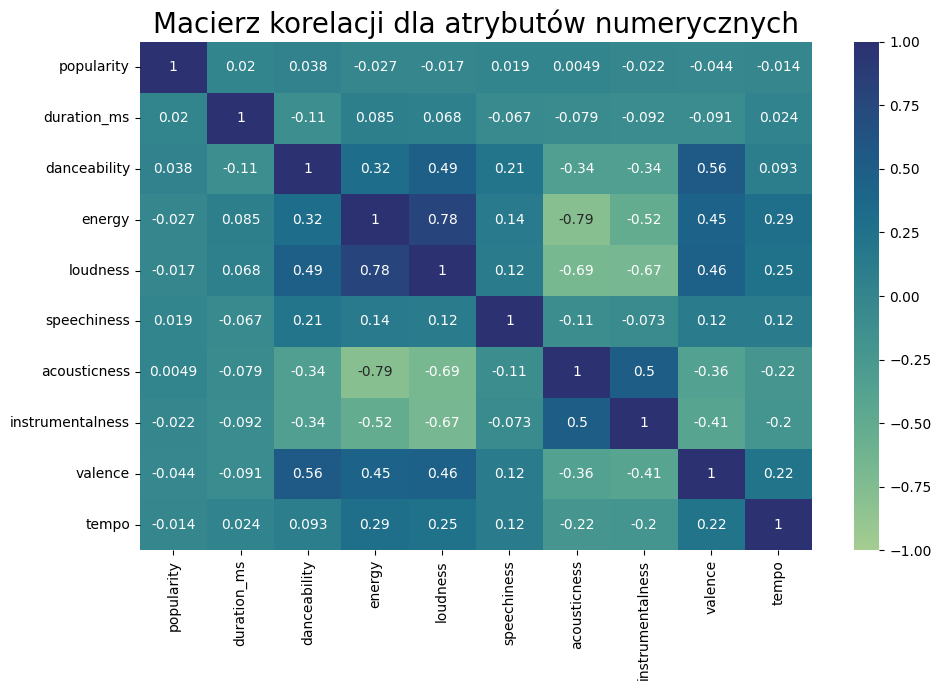

In [193]:
corr = df[COLUMNS_NUMERICAL].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1)
plt.title("Macierz korelacji dla atrybutów numerycznych", fontsize=20)
plt.tight_layout()
plt.show()

## Analiza atrybutów nominalnych

### Wykresy słupkowe

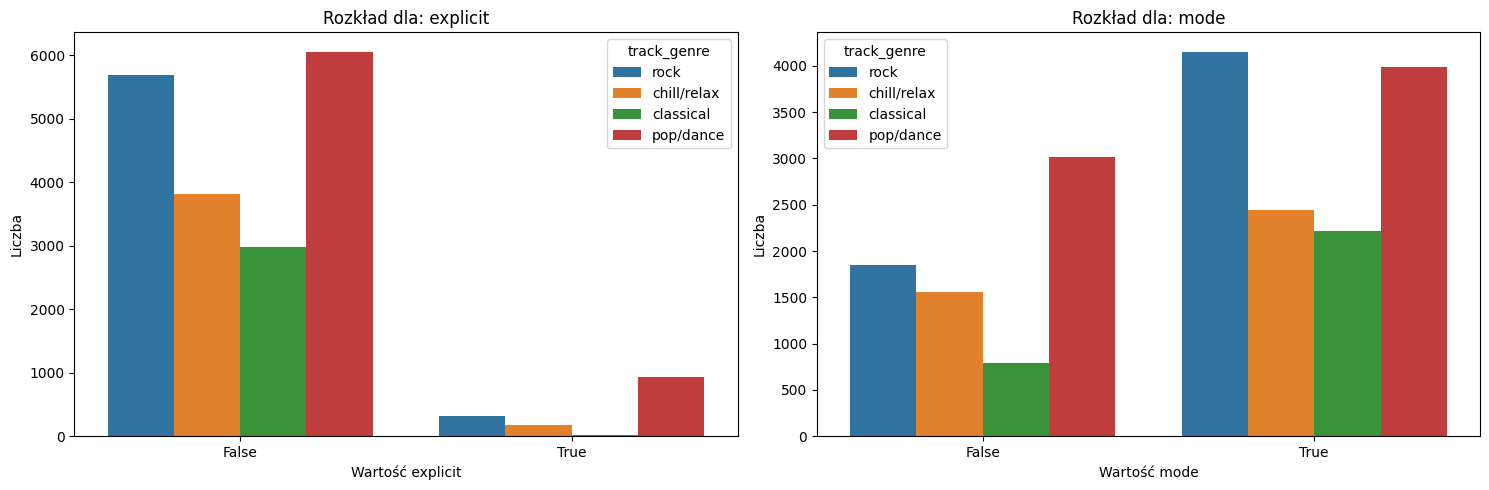

In [195]:
plt.figure(figsize=(15, 5))
for i, column in enumerate(COLUMNS_NOMINAL):
    plt.subplot(1, len(COLUMNS_NOMINAL), i + 1)
    sns.countplot(data=df, x=column, hue='track_genre')
    plt.title(f"Rozkład dla: {column}")
    plt.ylabel("Liczba")
    plt.xlabel(f"Wartość {column}")
plt.tight_layout()
plt.show()

# Modele uczenia maszynowego

## Przygotowanie danych

In [236]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 60

Podział danych na zbiór treningowy oraz testowy.

In [220]:
X, y = df.drop(columns='track_genre'), df['track_genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y)

## KNN - K najbliższych sąsiadów

In [239]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

 chill/relax       0.53      0.47      0.49       600
   classical       0.46      0.29      0.36       450
   pop/dance       0.60      0.71      0.65      1050
        rock       0.53      0.55      0.54       900

    accuracy                           0.55      3000
   macro avg       0.53      0.50      0.51      3000
weighted avg       0.54      0.55      0.54      3000



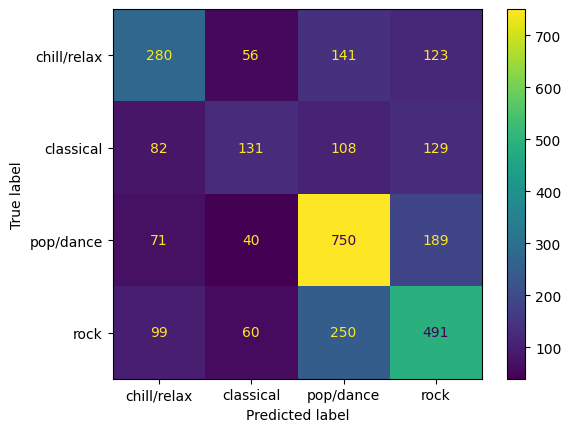

In [240]:
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

Wersja ze standaryzacją:

Best parameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

 chill/relax       0.80      0.73      0.76       600
   classical       0.75      0.68      0.71       450
   pop/dance       0.80      0.87      0.83      1050
        rock       0.80      0.81      0.81       900

    accuracy                           0.80      3000
   macro avg       0.79      0.77      0.78      3000
weighted avg       0.79      0.80      0.79      3000



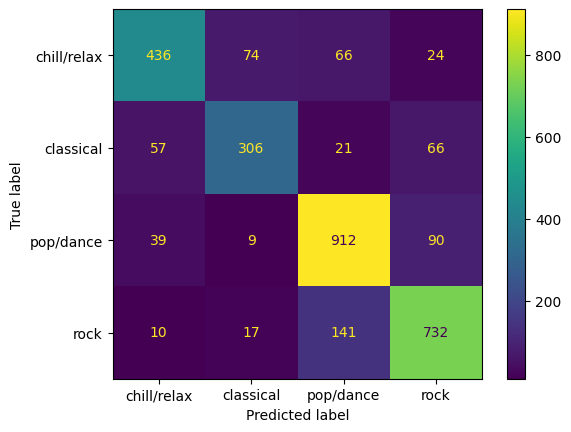

In [242]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.named_steps['knn'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['knn'].classes_)
disp.plot();

## Naive Bayes

              precision    recall  f1-score   support

 chill/relax       0.59      0.45      0.51       600
   classical       0.61      0.30      0.40       450
   pop/dance       0.49      0.80      0.61      1050
        rock       0.48      0.33      0.39       900

    accuracy                           0.51      3000
   macro avg       0.54      0.47      0.48      3000
weighted avg       0.53      0.51      0.49      3000



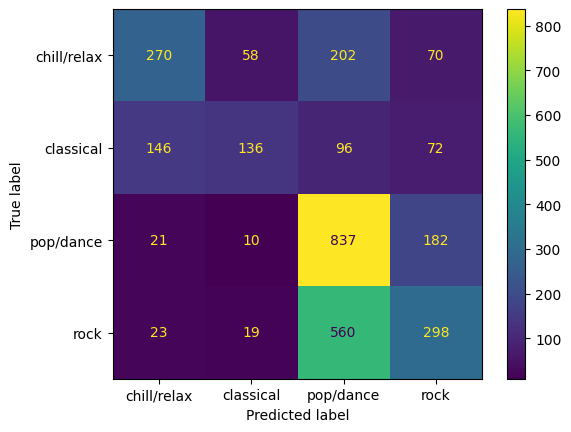

In [245]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

Wersja ze standaryzacją

              precision    recall  f1-score   support

 chill/relax       0.78      0.36      0.50       600
   classical       0.46      0.79      0.58       450
   pop/dance       0.70      0.65      0.67      1050
        rock       0.63      0.68      0.65       900

    accuracy                           0.62      3000
   macro avg       0.64      0.62      0.60      3000
weighted avg       0.66      0.62      0.62      3000



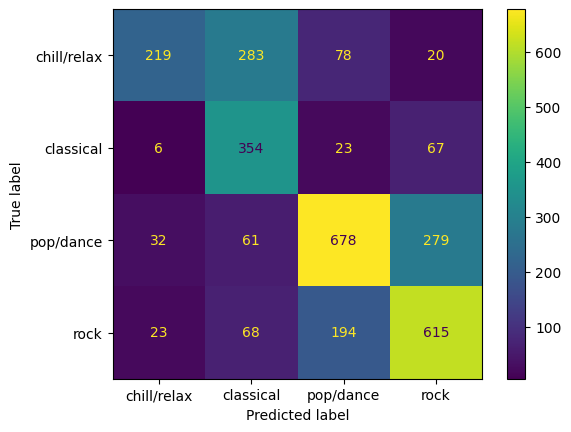

In [246]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=pipeline.named_steps['gnb'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['gnb'].classes_)
disp.plot();

## Drzewo decyzyjne

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

 chill/relax       0.76      0.71      0.73       600
   classical       0.74      0.64      0.69       450
   pop/dance       0.76      0.82      0.78      1050
        rock       0.74      0.76      0.75       900

    accuracy                           0.75      3000
   macro avg       0.75      0.73      0.74      3000
weighted avg       0.75      0.75      0.75      3000



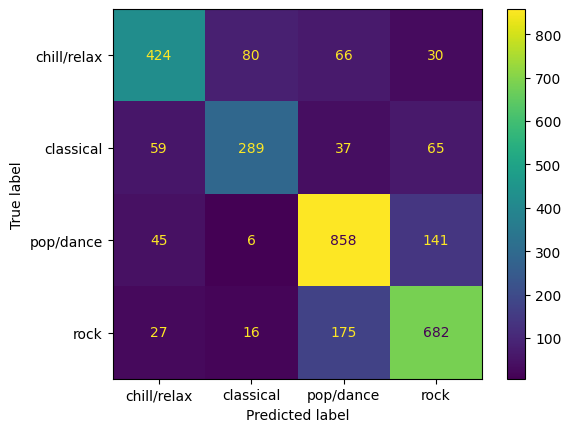

In [250]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

## Las losowy

Best parameters: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 400}
              precision    recall  f1-score   support

 chill/relax       0.82      0.75      0.79       600
   classical       0.78      0.71      0.74       450
   pop/dance       0.82      0.88      0.85      1050
        rock       0.83      0.85      0.84       900

    accuracy                           0.82      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.82      0.82      0.82      3000



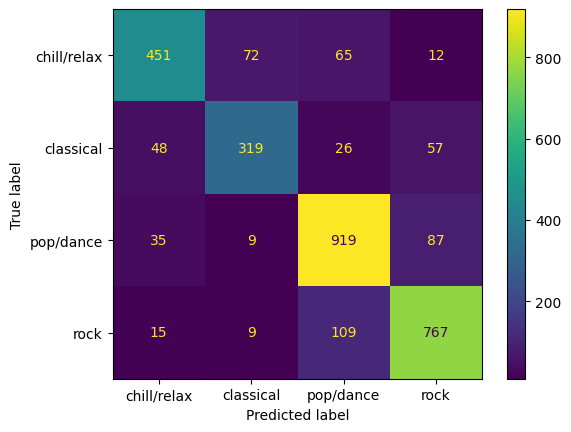

In [255]:
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

## AdaBoost

Best parameters: {'learning_rate': 1.0, 'n_estimators': 400}
              precision    recall  f1-score   support

 chill/relax       0.69      0.74      0.71       600
   classical       0.65      0.46      0.54       450
   pop/dance       0.73      0.75      0.74      1050
        rock       0.70      0.74      0.72       900

    accuracy                           0.70      3000
   macro avg       0.69      0.67      0.68      3000
weighted avg       0.70      0.70      0.70      3000



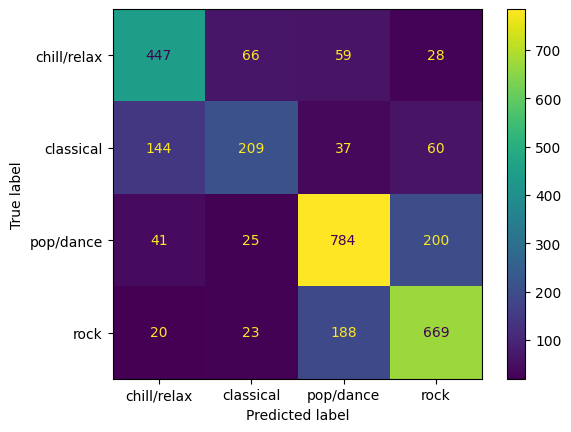

In [256]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

# Wnioski i podsumowanie modeli

# Interpretacja modeli

# Źródła

# Wykorzystane biblioteki oraz pakiety